# Infomap model

# Import relevant libraries

In [1]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pathlib
import pandas as pd
import infomap

# Load data

In [2]:
# setup data path
base_path = os.path.join('..', 'datasets')
file_path = os.path.join(base_path, 'starwars-full-interactions.json')

with open(file_path) as json_file:
    data = json.load(json_file)

# Initialize a graph

In [3]:
# set-up
metadata = data['nodes']
edges = data['links']

df_metadata = pd.DataFrame(metadata)
df_edges = pd.DataFrame(edges)

df_metadata.reset_index(inplace = True)

df_metadata.rename(columns = {'index' : 'node_id'}, inplace = True)

nodes_list = list(df_metadata.node_id)

edges_list = list(zip(df_edges.source, df_edges.target))

weight = list(df_edges.value)

# initialize a new graph object
G = nx.Graph()

# populate the graph with nodes
G.add_nodes_from(nodes_list)

# populate the graph with edges
G.add_edges_from(edges_list, edge_attr =df_edges.value)

# Implement the model

In [4]:
im = infomap.Infomap()

for i in range(len(df_edges)):
    # add edges and weights
    im.add_link(df_edges.source[i], df_edges.target[i], df_edges.value[i])
# run the model
im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

# get a dictionary with node id as key and respective community as value
communities = im.get_modules()
# if isolated node is observed, add that node the community 'x' which classified that the node has no community
for node in G.nodes:
    if node not in communities.keys():
        communities[node] = 'x'
nx.set_node_attributes(G, communities, 'community')

Found 12 modules with codelength: 4.62803196375345


In [5]:
# +1 from because there are isolated nodes
len(pd.Series(nx.get_node_attributes(G, 'community').values()).unique())

13

In [6]:
pd.Series(nx.get_node_attributes(G, 'community').values()).unique()

array([1, 3, 9, 2, 12, 10, 7, 11, 4, 6, 'x', 5, 8], dtype=object)

# Visualization

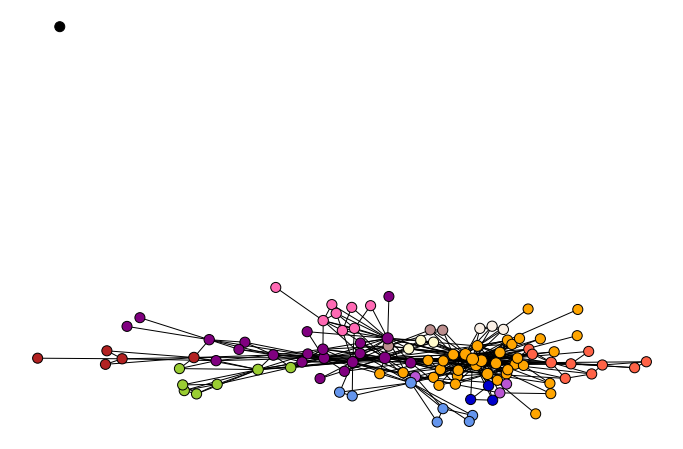

In [7]:
# plot decoration
plt.figure(figsize=(12, 8)) 

# map the color of each node with its community
colors = ['black', 'orange', 'purple', 'tomato', 'cornflowerblue', 'yellowgreen',
      'hotpink', 'lemonchiffon', 'firebrick', 'mediumblue', 'mediumorchid', 'rosybrown', 'linen']
color_map = []
# loop over nodes in G
for node in G:
    if communities[node] == 'x':
        color_map.append(colors[0])
    else:
        color_map.append(colors[communities[node]])

# position map
pos = nx.spring_layout(G)

# community index
communities = [c for c in nx.get_node_attributes(G, 'community').values()]
num_communities = len(pd.Series(communities).unique())

# edges
nx.draw_networkx_edges(G, pos)

# nodes
node_collection = nx.draw_networkx_nodes(
G, pos=pos, node_color = color_map, edgecolors= 'black',
node_size = [v+1 * 100 for v in dict(G.degree).values()])

plt.axis('off')
pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/infomap.png")

# Summary

In [8]:
# create a dictionary for summary
commu_dict = {}
for key, value in zip(communities, G.nodes):
    if key not in commu_dict.keys():
        commu_dict[key] = [value]
    else:
        commu_dict[key].append(value)

In [9]:
# manage result data
key_list = list(commu_dict.keys())
key_list.remove('x')
key_list = sorted(key_list)
key_list.append('x')
key_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'x']

In [10]:
# summarize the result
print("Number of communities: {}".format(len(commu_dict)))
print('-------------------------\n')
for key in key_list:
    print('Commu {}: {}\n'.format(key, commu_dict[key]))

Number of communities: 13
-------------------------

Commu 1: [0, 4, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 37, 38, 39, 44, 50, 53, 54, 55, 59, 60, 61, 62]

Commu 2: [21, 26, 64, 67, 70, 77, 78, 79, 82, 85, 87, 88, 89, 93, 94, 95, 96, 99, 101, 102, 104]

Commu 3: [1, 2, 3, 5, 6, 7, 22, 34, 51, 52]

Commu 4: [63, 68, 69, 80, 81, 84, 86]

Commu 5: [90, 91, 103, 105, 107, 108, 109]

Commu 6: [65, 66, 71, 72, 73, 74, 75, 83]

Commu 7: [47, 48, 49]

Commu 8: [92, 97, 98, 100, 106]

Commu 9: [15, 35, 36]

Commu 10: [43, 45, 46]

Commu 11: [56, 57, 58]

Commu 12: [40, 41, 42]

Commu x: [76]



# Not related for now

In [11]:
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality
import seaborn as sns

In [12]:
# degree
degree = degree_centrality(G)

# eigenvector_centrality
ec = eigenvector_centrality(G)

# betweeness centrality
bc = betweenness_centrality(G)

In [13]:
# visualize results
# --+ df
df = pd.DataFrame({'degree': degree, 'eigenvector_centrality': ec,
                   'betweenness_centrality': bc})

In [14]:
df

,degree,eigenvector_centrality,betweenness_centrality
0,0.238532,0.255767,0.036212
1,0.146789,0.139163,0.040897
2,0.018349,0.023463,0.000000
3,0.045872,0.049392,0.005642
4,0.321101,0.296814,0.212897
...,...,...,...
105,0.036697,0.004825,0.000000
106,0.009174,0.000181,0.000000
107,0.036697,0.004825,0.000000
108,0.045872,0.007994,0.000255


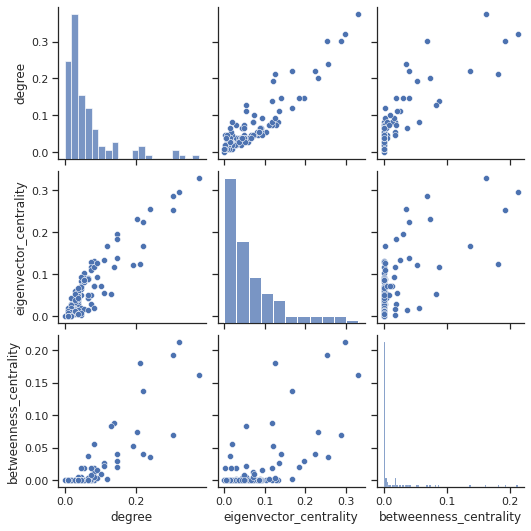

In [15]:
# --+ correlation matrix
df.corr()
# --+ scatter plot matrix

# visualization options
sns.set_theme(style="ticks")

sns.pairplot(df)